# MultiGPU training optimization

The next step will be a large hyperparameter optimization experiment using Optuna to find the best settings for our CNN model. Firs, we will run an experiment to determine the optimum number of worker processes to run per GPU. This experiment uses a representative CNN and multiprocessing to conduct short, dummy Optuna runs with increasing numbers of workers.

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Silence tensorflow, except for errors
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Standard library imports
import multiprocessing as mp
import threading
import time
from pathlib import Path

# Third party imports
import GPUtil
import matplotlib.pyplot as plt
import pandas as pd
import psutil

# Local imports
import configuration as config
from model_training import optimize_gpu_workers
from model_training.functions.utils import clear_tensorboard_logs

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/model_training'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

# Make sure the results directory exists
results_dir = f'{config.EXPERIMENT_RESULTS_DIRECTORY}/multi_gpu_optimization'
Path(results_dir).mkdir(parents=True, exist_ok=True)

# Set multiprocessing start method to 'spawn' to
# allow setting CUDA device in child processes
mp.set_start_method('spawn', force=True)

# clear_tensorboard_logs()

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1.1. Optuna runs

In [2]:
worker_nums = [1,2,3,4,5,6,7,8]
results_file = f'{results_dir}/multiGPU_optimization_worker-{"-".join(map(str, worker_nums))}.csv'

if Path(results_file).exists() == False:
    # Import memory monitoring libraries

    
    results = {
        'worker_count': [],
        'run_time': [],
        'total_steps': [],
        'max_system_memory_gb': [],
        'avg_system_memory_gb': [],
        'max_gpu0_memory_gb': [],
        'avg_gpu0_memory_gb': [],
        'max_gpu1_memory_gb': [],
        'avg_gpu1_memory_gb': []
    }
    
    def monitor_memory(monitoring_data, stop_event):
        '''Monitor system and GPU memory usage in a separate thread'''

        while not stop_event.is_set():
            # System memory
            system_mem = psutil.virtual_memory().used / (1024**3)  # Convert to GB
            monitoring_data['system_memory'].append(system_mem)
            
            # GPU memory
            try:
                gpus = GPUtil.getGPUs()
                if len(gpus) >= 1:
                    gpu0_mem = gpus[0].memoryUsed / 1024  # Convert MB to GB
                    monitoring_data['gpu0_memory'].append(gpu0_mem)
                else:
                    monitoring_data['gpu0_memory'].append(0)
                    
                if len(gpus) >= 2:
                    gpu1_mem = gpus[1].memoryUsed / 1024  # Convert MB to GB
                    monitoring_data['gpu1_memory'].append(gpu1_mem)
                else:
                    monitoring_data['gpu1_memory'].append(0)
            except:
                monitoring_data['gpu0_memory'].append(0)
                monitoring_data['gpu1_memory'].append(0)
            
            time.sleep(0.5)  # Sample every 0.5 seconds

    for workers in worker_nums:
        print(f'Running optimization with {workers} workers')
        
        # Initialize memory monitoring
        monitoring_data = {
            'system_memory': [],
            'gpu0_memory': [],
            'gpu1_memory': []
        }
        stop_event = threading.Event()
        
        # Start memory monitoring thread
        monitor_thread = threading.Thread(target=monitor_memory, args=(monitoring_data, stop_event))
        monitor_thread.start()

        start_time = time.time()

        with mp.Pool(processes=workers) as pool:
            pool.map(optimize_gpu_workers.run, range(workers))

        run_time = time.time() - start_time
        
        # Stop memory monitoring
        stop_event.set()
        monitor_thread.join()

        # Calculate memory statistics
        max_sys_mem = max(monitoring_data['system_memory']) if monitoring_data['system_memory'] else 0
        avg_sys_mem = sum(monitoring_data['system_memory']) / len(monitoring_data['system_memory']) if monitoring_data['system_memory'] else 0
        
        max_gpu0_mem = max(monitoring_data['gpu0_memory']) if monitoring_data['gpu0_memory'] else 0
        avg_gpu0_mem = sum(monitoring_data['gpu0_memory']) / len(monitoring_data['gpu0_memory']) if monitoring_data['gpu0_memory'] else 0
        
        max_gpu1_mem = max(monitoring_data['gpu1_memory']) if monitoring_data['gpu1_memory'] else 0
        avg_gpu1_mem = sum(monitoring_data['gpu1_memory']) / len(monitoring_data['gpu1_memory']) if monitoring_data['gpu1_memory'] else 0
        
        # Store results
        results['run_time'].append(run_time)
        results['worker_count'].append(workers)
        results['total_steps'].append(workers * 4 * 10 * 10)
        results['max_system_memory_gb'].append(max_sys_mem)
        results['avg_system_memory_gb'].append(avg_sys_mem)
        results['max_gpu0_memory_gb'].append(max_gpu0_mem)
        results['avg_gpu0_memory_gb'].append(avg_gpu0_mem)
        results['max_gpu1_memory_gb'].append(max_gpu1_mem)
        results['avg_gpu1_memory_gb'].append(avg_gpu1_mem)
        
        print(f'Runtime: {run_time:.1f}s, Max System Memory: {max_sys_mem:.1f}GB, Max GPU0: {max_gpu0_mem:.1f}GB, Max GPU1: {max_gpu1_mem:.1f}GB\n')

        # Wait a bit before starting the next run
        time.sleep(10)

    results_df = pd.DataFrame(results)
    results_df['step_rate'] = results_df['total_steps'] / results_df['run_time']
    results_df['max_total_gpu_memory_gb'] = results_df['max_gpu0_memory_gb'] + results_df['max_gpu1_memory_gb']
    results_df['avg_total_gpu_memory_gb'] = results_df['avg_gpu0_memory_gb'] + results_df['avg_gpu1_memory_gb']
    results_df.to_csv(results_file, index=False)

else:
    results_df = pd.read_csv(results_file)

In [3]:
results_df['step_rate'] = results_df['total_steps'] / results_df['run_time']
results_df['max_total_gpu_memory_gb'] = results_df['max_gpu0_memory_gb'] + results_df['max_gpu1_memory_gb']
results_df['avg_total_gpu_memory_gb'] = results_df['avg_gpu0_memory_gb'] + results_df['avg_gpu1_memory_gb']
results_df.head()

,worker_count,run_time,total_steps,max_system_memory_gb,avg_system_memory_gb,max_gpu0_memory_gb,avg_gpu0_memory_gb,max_gpu1_memory_gb,avg_gpu1_memory_gb,step_rate,max_total_gpu_memory_gb,avg_total_gpu_memory_gb
0,1,124.567567,400,11.041821,10.197458,0.011719,0.011719,2.839844,2.656956,3.211109,2.851562,2.668675
1,2,143.355556,800,13.468056,12.166678,2.839844,2.636996,2.839844,2.637011,5.580530,5.679688,5.274007
2,3,156.957079,1200,15.975388,14.134401,2.839844,2.663156,5.668945,5.315475,7.645402,8.508789,7.978631
3,4,170.820144,1600,18.467010,16.165360,5.668945,5.341406,5.668945,5.341409,9.366577,11.337891,10.682814
4,5,193.991630,2000,21.126728,18.354149,5.668945,5.380543,8.497070,7.968673,10.309723,14.166016,13.349216


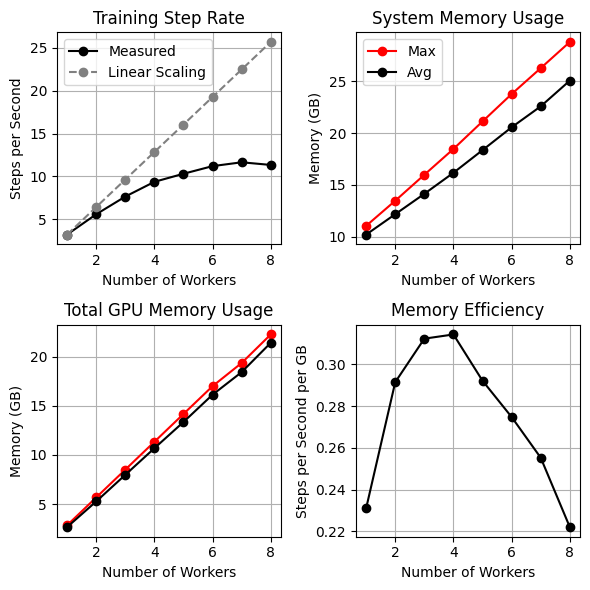

In [4]:
# Memory usage visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))

one_worker_step_rate = results_df.loc[results_df['worker_count'] == 1, 'step_rate'].values[0]

# Training step rate
ax1.plot(results_df['worker_count'], results_df['step_rate'], 'o-', color='black', label='Measured')
ax1.plot(list(range(1,9)), [one_worker_step_rate * i for i in range(1,9)], 'o--', color='gray', label='Linear Scaling')
ax1.set_title('Training Step Rate')
ax1.set_xlabel('Number of Workers')
ax1.set_ylabel('Steps per Second')
ax1.legend()

ax1.grid(True)

# System memory usage
ax2.plot(results_df['worker_count'], results_df['max_system_memory_gb'], 'o-', color='red', label='Max')
ax2.plot(results_df['worker_count'], results_df['avg_system_memory_gb'], 'o-', color='black', label='Avg')
ax2.set_title('System Memory Usage')
ax2.set_xlabel('Number of Workers')
ax2.set_ylabel('Memory (GB)')
ax2.legend()
ax2.grid(True)

# Total GPU memory usage
ax3.plot(results_df['worker_count'], results_df['max_total_gpu_memory_gb'], 'o-', color='red', label='Max')
ax3.plot(results_df['worker_count'], results_df['avg_total_gpu_memory_gb'], 'o-', color='black', label='Avg')
ax3.set_title('Total GPU Memory Usage')
ax3.set_xlabel('Number of Workers')
ax3.set_ylabel('Memory (GB)')
ax2.legend()
ax3.grid(True)

# Memory efficiency (steps per GB of total memory)
total_max_memory = (results_df['max_system_memory_gb'] + 
                   results_df['max_gpu0_memory_gb'] + 
                   results_df['max_gpu1_memory_gb'])

memory_efficiency = results_df['step_rate'] / total_max_memory

ax4.plot(results_df['worker_count'], memory_efficiency, 'o-', color='black')
ax4.set_title('Memory Efficiency')
ax4.set_xlabel('Number of Workers')
ax4.set_ylabel('Steps per Second per GB')
ax4.grid(True)

plt.tight_layout()
plt.show()

fig.savefig(
    f'{figures_dir}/03.1.1-multiGPU_worker_count_optimization.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)